# Recurrent Neural Networks with TensorFlow
In this note book we implement an LSTM based Recurrent Neural Network (RNN) classifier, for MNIST database of handwritten digits. For more useful reading on RNN try the following links. In this notebook I try to combine the good parts of all the following links while presenting a structral and classified view on RNN in TensorFlow.
1. __[wildml's](http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/)__ post on RNNs in Tensorflow by Denny Britz. He provides an in depth understanding of RNN in TF, while discuss some undocumented issues.
2. __[RNN_for_mnist](https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-2-f7e5ece849f5)__ and its __[cloab_page](https://colab.research.google.com/drive/18FqI18psdH30WUJ1uPd6zVgK2AwxO_Bj#scrollTo=A-fpqklBefZy)__ by Ceshine Lee.
3. __[Morvan_Zhou's](https://github.com/MorvanZhou/Tensorflow-Tutorial/blob/master/tutorial-contents/402_RNN_classification.py)__ RNN implementation.

Before delving into more details let us import the necessary libraries.



In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

### MNIST Dataset Overview
The MNIST database of handwritten digits, available from this __[Page](http://yann.lecun.com/exdb/mnist/)__, has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image (28$\times$28 pixels where each pixel has a value within the interval [0,1]). Let us load the mnist.

In [22]:
import tensorflow as tf

#One way of loading mnist given below. But it does not provide the next_batch functionality and also if you write it yourself, you should also take care of data shuffling at th end of one epoch.
from tensorflow.python.keras._impl.keras.utils import np_utils # Note <from tensorflow.keras.utils import np_utils> does not work and this is just a work around. See https://github.com/tensorflow/tensorflow/issues/14008
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data(path='/home/meysam/github/Datasets/mnist/mnist.npz')
x_train, x_test = x_train / 255.0, x_test / 255.0


# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
'''
# This other version is depracted and give warning but at least give you next batc
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''

'\n# This other version is depracted and give warning but at least give you next batc\nold_v = tf.logging.get_verbosity()\ntf.logging.set_verbosity(tf.logging.ERROR)\nfrom tensorflow.examples.tutorials.mnist import input_data\nmnist = input_data.read_data_sets("/tmp/data/", one_hot=True)\n'

In [24]:
y_train.shape
len(y_train)

60000

In [ ]:
def nextBatch(batch_size,inputs,labels,batch_num):
    len(inputs)

Now let us define a function for ploting mnist images and their class label, in a grid with desired size.

In [138]:
def plot_func(grid_heigh,grid_width,images,lables,ShowLabel=None,ShowPred=None,Pred=None):
    assert images.shape[0] == (grid_heigh*grid_width)
    assert images.shape[0] == lables.shape[0]
    if Pred is not None:
        assert lables.shape[0] == Pred.shape[0]
    figs, axes = plt.subplots(nrows=grid_heigh, ncols=grid_width)
    figs.subplots_adjust(hspace=0.3, wspace=0.2)
    for index,ax in enumerate(axes.flat): # axes.flat is required as axes has grid structure
        ax.imshow(images[index], cmap='gray')
        if ShowLabel:
            ax.set_xlabel('label:{0}'.format(lables[index]))
        if ShowPred:
            ax.set_xlabel('label:{0}, Pred:{1}'.format(lables[index],Pred[index]))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


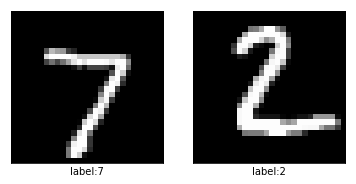

In [139]:
plot_func(1,2,x_test[0:2],y_test[0:2],ShowLabel=True,ShowPred=None,Pred=None)


# LSTM Based RNN in TensorFlow - A Closer Look into Details
In order to implement any RNN in TF, we need to clearly determine two things:
1. The RNN itself, which we can either use a static or a dynamic RNN, as shown below.
    1. tf.contrib.rnn.static_rnn (or its aliase tf.nn.static_rnn) 
    2. tf.nn.dynamic_rnn
2. The cell that is being used by the RNN, which also can have many different implementations as shown below:
    1. tf.nn.rnn_cell.BasicLSTMCell (aliase with 2) (this one is deprecated)
    2. tf.contrib.rnn.BasicLSTMCell (aliase with 1) (this one is deprecated)
    3. tf.contrib.rnn.LSTMCell (which is an aliase of 4)
    4. tf.nn.rnn_cell.LSTMCell (which is an aliase of 3)
    5. tf.contrib.rnn.LSTMBlockCell
    6. tf.contrib.rnn.LSTMBlockFusedCell
So, the question is which RNN (static or dynamic) and which LSTM cell (6 cases) shall we use? This is discussed belwo.

## Static VS Dynamic RNN:
Here we explain whether we use static or dynamic RNN. In short, it is better to use dynamic RNN while we should be careful when we have inputs with different length (number of time steps). 

Static RNN creates an unrolled graph for a fixed RNN length. That means, if you call tf.nn.rnn with inputs having 200 time steps you are creating a static graph with 200 RNN steps. First, graph creation is slow. Second, you’re unable to pass in longer sequences (> 200) than you’ve originally specified. 

*tf.nn.dynamic_rnn* solves this. It uses a tf.While loop to dynamically construct the graph when it is executed. That means graph creation is faster and you can feed batches of variable size. So dynamic RNN is faster and more flexible.

Also, based on __[here](https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-2-f7e5ece849f5)__, we can supply the whole batch of input data as a tensor to dynamic_rnn instead of slicing them into a list of tensor (sequences). This is easier to write and read than static_rnn. See the code below:

<div class="alert alert-block alert-info">
<b>Important Note on the shape of the input and outputs for RNN (tf.nn.dynamic_rnn) </b>:
    
If time_major == False (default mode) then 
- input must be a Tensor of shape: [batch_size, max_time, ...], or a nested tuple of such elements.
- outputs will be a Tensor shaped: [batch_size, max_time, cell.output_size]
- state: The final state. If cell.state_size is an int, this will be shaped [batch_size, cell.state_size]. If it is a TensorShape, this will be shaped [batch_size] + cell.state_size

For exampl let’s say you have a batch of two examples, one is of length 13, and the other of length 20. Each one is a vector of 128 numbers. The length 13 example is 0-padded to length 20. Then your RNN input tensor is of shape [2, 20, 128]. The dynamic_rnn function returns a tuple of (outputs, state), where outputs is a tensor of size [2, 20, ...] with the last dimension being the RNN output at each time step. state is the last state for each example, and it’s a tensor of size [2, ...] where the last dimension also depends on what kind of RNN cell you’re using.
</div>

<div class="alert alert-block alert-danger">
<b>Using Dynam RNN Requires Caution if we have inputs with different length (time steps)</b>: In the above example, once you reach time step 13, your first example in the batch is already “done” and you don’t want to perform any additional calculation on it. The second example isn’t and must go through the RNN until step 20. Hence we need to pass something called sequence_length. By passing sequence_length=[13,20] you tell Tensorflow to stop calculations for example 1 at step 13 and simply copy the state from time step 13 to the end. The output will be set to 0 for all time steps past 13. You’ve just saved some computational cost. But more importantly, if you didn’t pass sequence_length you would get incorrect results! Without passing sequence_length, Tensorflow will continue calculating the state until T=20 instead of simply copying the state from T=13. This means you would calculate the state using the padded elements, which is not what you want.
</div>

For example if we have an input batch X with two inputs and length of first one is 10 and second is 6 as below, then here is how we pass the sequence_length to the tf.nn.dynamic_rnn.

Also further discussion on dynamic and static RNN can be found at __[stackoverflow](https://stackoverflow.com/questions/39734146/whats-the-difference-between-tensorflow-dynamic-rnn-and-rnn)__, __[github](https://github.com/tensorflow/tensorflow/issues/3801)__. Also some further discussions on RNN with tensorflow is avaliable at __[wildml](http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/)__ and __[Here](https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-2-f7e5ece849f5)__.

# The Choice of LSTM Cell:
For LSTM we intrduced 6 cases, but as the first two implementations are depracted and the third and fourth are aliases, we have 3 major options. A detailed discussion on these cases can be found in this __[page](https://returnn.readthedocs.io/en/latest/tf_lstm_benchmark.html)__. 
1. tf.nn.rnn_cell.LSTMCell  
2. tf.contrib.rnn.LSTMBlockCell
3. tf.contrib.rnn.LSTMBlockFusedCell

<div class="alert alert-block alert-info">
tf.contrib contains volatile and experimental code, and at some point it will be removed. While, tf.nn is said to contain wrappers for primitive neural net operations, and hence is more reliable. Refer to TF official page and check their explanation on the API for details.
</div>

Also, based on my check from tensorflow documentaion, *tf.nn.rnn_cell.LSTMCell* receives more arguments (e.g. state_is_tuple=True). Hence it looks like a better choice.

# RNN Implementation
Now we implement an LSTM based RNN to classify MNIST. I suggest to take a look at colah's __[Page](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)__ for further discussions on LSTM. 

In what follows, we implement a single layer RNN network with LSTM cells with the following parameters:
- num_hidden $\leftrightarrow$ is the number of neurons for each neural network within the LSTM cell. Note that LSTM has 4 neural nets within itself. 
- num_steps $\leftrightarrow$ is the number of time steps we consider for our RNN
- num_input $\leftrightarrow$ is the dimenssion of the each input, or equivalently, the number of features. 

As a side practice try to count the number of parameters that we have by (4 ((num_input + num_hidden ) x num_hidden+1)), as we have 4 neural network in one LSTMM cell, each of which has an input size of (num_input + num_hidden) where the former is due to input and the latter is due to the activation comming from previous layer. Also at the hidden layer we have num_hidden neurons and one bias parameter.
Let us now write the model. First we need to initialze some parameters.

In [ ]:
tf.reset_default_graph() # in the begining of the code to avoid namespace error
num_hidden = 64
num_steps = 28  # as we want to read the images column by column
num_input = 28 # as one column of image is 28 pixels
num_classes = num_classes # 10 classes

<div class="alert alert-block alert-info">
<b>NOTE</b>: Tensorflow’s RNN functions expect a tensor of shape [B, T, ...] as input, where B is the batch size and T is the length in time of each input (e.g. the number of words in a sentence, or num_steps). The last dimensions depend on your data.
</div>

In [ ]:
X = tf.placeholder(tf.float32, [None, num_steps, num_inputs])
Y = tf.placeholder(tf.float32,[None,num_classes])

In [ ]:
def RNN_model(x,num_classes): 
    
    
    # Define an lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units = num_hidden,state_is_tuple=True) #lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, last_states = tf.nn.dynamic_rnn(cell=lstm_cell,  # an instance of RNN cell
                                             inputs=x,        # The RNN inputs. If time_major == False (default), this must be a Tensor of shape: [batch_size, max_time, ...], or a nested tuple of such elements
                                             dtype=tf.float32 # It is NOT optional, if we do not provide 
                                             # sequence_length = sequence_length # this one is optional (read the note above on sequence_length). When all our input data points have the same number of time steps
                                             # time_major = False # It is optional. time_major determines the shape format of the inputs and outputs Tensors. If true, these Tensors must be shaped [max_time, batch_size, depth]. If false, these Tensors must be shaped [batch_size, max_time, depth].
                                            )
    # outputs: is the RNN output tensor. If time_major == False (default), this will be a Tensor shaped: [batch_size, max_time, cell.output_size]
    #last_states:is the final state of RNN.  cell.state_size is an int, this will be shaped [batch_size, cell.state_size]. If it is a TensorShape, this will be shaped [batch_size] + cell.state_size
    
    
    output_layer = tf.layers.Dense(
        num_classes, activation=None, 
        kernel_initializer=tf.orthogonal_initializer()
    )
    return output_layer(tf.layers.batch_normalization(outputs[:, -1, :]))

If you were interested in a bidirectional RNN with LSTM cells, check this __[page](http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/)__. Now let us create the graph,.

In [ ]:
logits = RNN_model(x,num_classes)
predictions = tf.nn.softmax(logits)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y,logits=logits))
optimizer = tf.train.AdamOptimizer().minize(cost)

accuracy = tf.reduce_mean( (tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(Y,1)),dtype=tf.float32)) )

#saver = tf.train.Saver()


init = tf.global_variables_initializer()
with tf.Sess() as sess:
    sess.run(init)
    
                          
                          
